In [1]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt

### Creating Mask

In [43]:
path = '../data/shapefile/geo_export.shp'
chicago = gpd.read_file(path)
chicago = chicago.dissolve()

xmin, ymin, xmax, ymax = chicago.total_bounds
n_x_cells = 50
x_cell_size = (xmax - xmin) / n_x_cells
n_y_cells = round(((xmax - xmin)/(ymax - ymin))*n_x_cells)
y_cell_size = (ymax - ymin) / n_y_cells
mask_global = np.ones((n_y_cells, n_x_cells))
x_arange = np.arange(xmin, xmax+x_cell_size, x_cell_size)
y_arange = np.arange(ymin, ymax+y_cell_size, y_cell_size)
for i, y0 in zip(range(n_y_cells-1, -1, -1), y_arange):
    for j, x0 in zip(range(n_x_cells), x_arange):
        x1 = x0-x_cell_size
        y1 = y0+y_cell_size
        box = shapely.geometry.box(x0, y0, x1, y1)
        if not chicago.intersection(box).any():
            mask_global[i,j] = 0

### Creating 4 windows

In [44]:
windows = []
masks = []
for i in [(0, int(2/3*55)), (55-int(2/3*55), 55)]:
    for j in [(0, int(2/3*50)), (50-int(2/3*50), 50)]:

        window = np.zeros((55,50))
        window[i[0]:i[1], j[0]:j[1]] = 1
        windows.append(window)

        mask_cropped = mask_global[i[0]:i[1], j[0]:j[1]]
        masks.append((mask_cropped, i, j))

### Training 4 Hetero-ConvLSTMS

In [75]:
lookback = 7
batch_size = 4

train_X_crimes_only = np.load('../data/train_data.npy')
test_X_crimes_only = np.load('../data/test_data.npy')

test_preds = []

for mask, i, j in masks:
    
    train_windowed_X = train_X_crimes_only[:, i[0]:i[1], j[0]:j[1]] * mask
    train_windowed_X = train_windowed_X.reshape(*train_windowed_X.shape, 1)
    test_windowed_X = test_X_crimes_only[:, i[0]:i[1], j[0]:j[1]] * mask
    test_windowed_X = test_windowed_X.reshape(*test_windowed_X.shape, 1)

    train_gen = TimeseriesGenerator(
        train_windowed_X,
        train_windowed_X,
        length=lookback,
        batch_size=batch_size,
        shuffle=False
    )
    test_gen = TimeseriesGenerator(
        test_windowed_X,
        test_windowed_X,
        length=lookback,
        batch_size=batch_size,
        shuffle=False
    )

    mask = tf.keras.backend.constant(mask)
    mask = tf.expand_dims(mask, -1)

    def masked_MSE_loss(y_true, y_pred):
        y_pred_masked = tf.math.multiply(y_pred, mask)
        mse = tf.keras.losses.mean_squared_error(y_true = y_true, y_pred = y_pred_masked)
        return mse

    # Define the input tensors
    inputs = Input(shape=(lookback, *train_windowed_X.shape[1:]))

    # First stack of convlstm layers
    convlstm1 = layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', activation='tanh', return_sequences=True)(inputs)
    bathnorm1 = layers.BatchNormalization()(convlstm1)
    convlstm2 = layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', activation='tanh', return_sequences=False)(bathnorm1)

    # Second stack of convlstm layers
    convlstm3 = layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', activation='tanh', return_sequences=True)(inputs)
    batchnorm2 = layers.BatchNormalization()(convlstm3)
    convlstm4 = layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', activation='tanh', return_sequences=False)(batchnorm2)

    # Concatenate outputs of two stacks
    concatenation = layers.concatenate([convlstm2, convlstm4])
    outputs = layers.Conv2D(filters=1, kernel_size=1, padding="same", activation='linear')(concatenation)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam', loss=masked_MSE_loss, metrics=['mae'])

    # Train the model
    model.fit(train_gen, epochs=1)

    # Create test prediction
    test_pred = model.predict(test_gen)
    test_pred *= mask

    test_preds.append(test_pred)

90/90 [==============================] - 7s 73ms/step


### Use model ensemble to create final prediction

In [76]:
ground_truth = test_X_crimes_only[7:]
sum_pred = np.zeros_like(ground_truth)
for (mask, i, j), test_pred in zip(masks, test_preds):
    sum_pred[:, i[0]:i[1], j[0]:j[1]] += test_pred[:, :, :, 0]

sum_windows = np.sum(windows, axis=0, dtype='float64')
final_pred = sum_pred/sum_windows
np.save('../data/final_pred_Cr_linear.npy', final_pred)

### Plotting Results

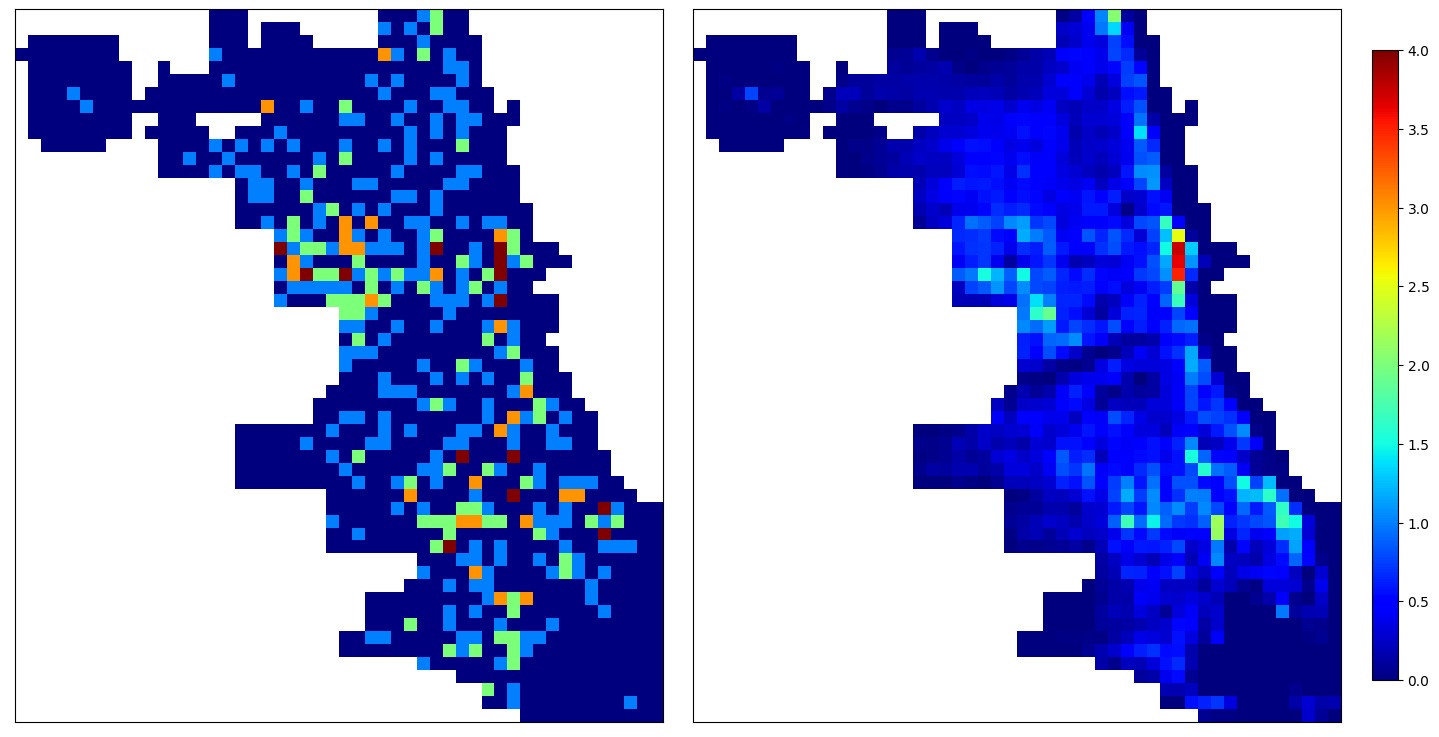

In [110]:
test_X_crimes_only = np.load('../data/test_data.npy')
final_pred = np.load('../data/final_pred_Cr_relu.npy')

test_X_crimes_only[-1][mask_global == False] = np.nan

final_pred_clip = np.clip(final_pred, 0, None)

last_day_truth = test_X_crimes_only[-1]
last_day_pred = final_pred_clip[-1]
last_day_pred[mask_global == False] = np.nan

fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=-2)
fig.set_figheight(7)
fig.set_figwidth(13)
im = axs[0].imshow(last_day_truth, cmap='jet', vmin=0, vmax=4)
im = axs[1].imshow(last_day_pred, cmap='jet', vmin=0, vmax=4)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
cbar_ax = fig.add_axes([1.05, 0.07, 0.02, 0.9])
fig.colorbar(im, orientation='vertical', cax=cbar_ax)
plt.show()

### Final Scores

In [62]:
mse = np.nanmean(np.square(np.subtract(ground_truth, final_pred)))
print(f'Hetero-ConvLSTM - MSE: {mse.mean():.4f}')
print(f'Hetero-ConvLSTM - RMSE: {np.sqrt(mse).mean():.4f}')

Hetero-ConvLSTM - MSE: 0.2506
Hetero-ConvLSTM - RMSE: 0.5006
